# Multiforest optimization notebook

Above the code cells, there are short instructions how the users can modify the codes in the cells. If there are no instructions, no changes should be needed for the cell by default.

A detailed description is provided in the <b>README.md</b>.

## Basic definitions

Simulated forest data - name and climate scenario

In [1]:
RCP = "RCP0" # no climate change
filename = "rslt_"+RCP+"_keskisuomi_V11_smooth.zip" # Test data from Central Finland with 2925 forest stands 

Specify policy scenario: 
* "NFS" - National Forest Strategy
* "BDS" - Biodiversity Strategy
* "BES" - Bioeconomy Strategy

In [2]:
scenario = "BES" 

Name definition for saved output, rule: _scenario_RCP_extension

In [3]:
extension = "test" # some additional info to the saved output 

## Read the data

In [4]:
import multiFunctionalOptimization as MFO

In [5]:
from importlib import reload
reload(MFO)

<module 'multiFunctionalOptimization' from '/home/markus/dev/MultiForestDemonstration/multiFunctionalOptimization.py'>

If no solver is specified, the open source solver CLP is used

In [6]:
mfo = MFO.MultiFunctionalOptimization() 

'Using CLP'

In [7]:
import wget
import os
import pandas as pd

Data will be automatically downloaded at the first use!

In [8]:
if not filename in os.listdir("."):
    wget.download("https://a3s.fi/swift/v1/AUTH_9d5edfac7197434ab0e9b60b9f62c600/keskisuomi/"+filename)

In [9]:
%%time
mfo.readData(filename,
             sampleRatio=0.01 #If no sample ratio given, the ratio is assumed to be 1.
            )                

'sample size 29/2925(0%)'

CPU times: user 1.08 s, sys: 212 ms, total: 1.3 s
Wall time: 1.29 s


## Create some new variables in the data

Calculate total (per stand) values from relative values:
* "Relative to Area" = simulated indicator value relate to one hectar -> scaled to represented area of NFI plot <br>
* ("Relative to volume" = indicator relates to standing Volume -> scaled to the represented volume of the plot) <br>
* ("Absolute Value" = takes the inticator value as it is)

In [10]:
columnTypes = {
    'i_Vm3':(float,"Relative to Area"),
    'Harvested_V':(float,"Relative to Area"),
    'Harvested_V_log_under_bark':(float,"Relative to Area"), 
    'Harvested_V_pulp_under_bark':(float,"Relative to Area"),
    'Harvested_V_under_bark':(float,"Relative to Area"), 
    'Biomass':(float,"Relative to Area"),
    'ALL_MARKETED_MUSHROOMS':(float,"Relative to Area"), 
    'BILBERRY':(float,"Relative to Area"), 
    'COWBERRY':(float,"Relative to Area"),
    'HSI_MOOSE':(float,"Relative to Area"),
    'CAPERCAILLIE':(float,"Relative to Area"), 
    'HAZEL_GROUSE':(float,"Relative to Area"), 
    'V_total_deadwood':(float,"Relative to Area"), 
    'N_where_D_gt_40':(float,"Relative to Area"),
    'prc_V_deciduous':(float,"Relative to Area"),
    'CARBON_SINK':(float,"Relative to Area"), 
    'Recreation':(float,"Relative to Area"),
    'Scenic':(float,"Relative to Area")
}

In [11]:
mfo.calculateTotalValuesFromRelativeValues(columnTypes=columnTypes)

List the new created columns: <br>
* Total_... hectare value multiplied by represented area (or volume)

In [12]:
[name for name in mfo.data.columns if "Total_" in name and "Relative" not in name]

['Total_i_Vm3',
 'Total_Harvested_V',
 'Total_Harvested_V_log_under_bark',
 'Total_Harvested_V_pulp_under_bark',
 'Total_Harvested_V_under_bark',
 'Total_Biomass',
 'Total_ALL_MARKETED_MUSHROOMS',
 'Total_BILBERRY',
 'Total_COWBERRY',
 'Total_HSI_MOOSE',
 'Total_CAPERCAILLIE',
 'Total_HAZEL_GROUSE',
 'Total_V_total_deadwood',
 'Total_N_where_D_gt_40',
 'Total_prc_V_deciduous',
 'Total_CARBON_SINK',
 'Total_Recreation',
 'Total_Scenic']

## Create new column
1) Column indicating if regime is "CCF_3, CCF_4, BAUwGTR" (TRUE/FLASE) <br>
Important for FES Biodiversity, allowed regimes for conservation sites.

2) Column indicating if regime is "SA" (TRUE/FALSE)<br>
Important for FES Biodiversity, allowed regimes for statutory protection sites.

3) Column indicating if regime is "BAUwT_B, BAUwT_5_B, BAUwT_15_B, BAUwT_30_B, BAUwT_GTR_B" <br>
Important for FES Resillience, allowed regimes for climate change adaption.

In [13]:
regimeClassNames = {"regimeClass0name":"CCF","regimeClass1name":"SA","regimeClass2name":"Broadleave"}
regimeClassregimes = {"regimeClass0regimes":["CCF_3","CCF_4","BAUwGTR"],"regimeClass1regimes":["SA"],"regimeClass2regimes":["BAUwT_B", "BAUwT_5_B", "BAUwT_15_B", "BAUwT_30_B", "BAUwT_GTR_B"]}

In [14]:
mfo.addRegimeClassifications(regimeClassNames = regimeClassNames,regimeClassregimes=regimeClassregimes)

## Define initial value
1) Define initial values, recognized by the regime "initial_state", which only occurs at the first year (here 2016)

2) Create new variables that describe the <b>relative change to initial situation (start year) "Relative_"</b>:

In [15]:
mfo.finalizeData(initialRegime="initial_state")

New variables created:

In [16]:
[name for name in mfo.data.columns if "Relative_" in name]

['Relative_V',
 'Relative_ALL_MARKETED_MUSHROOMS',
 'Relative_BILBERRY',
 'Relative_COWBERRY',
 'Relative_HSI_MOOSE',
 'Relative_CAPERCAILLIE',
 'Relative_HAZEL_GROUSE',
 'Relative_V_total_deadwood',
 'Relative_prc_V_deciduous',
 'Relative_Recreation',
 'Relative_Scenic',
 'Relative_CARBON_STORAGE',
 'Relative_Total_ALL_MARKETED_MUSHROOMS',
 'Relative_Total_BILBERRY',
 'Relative_Total_COWBERRY',
 'Relative_Total_HSI_MOOSE',
 'Relative_Total_CAPERCAILLIE',
 'Relative_Total_HAZEL_GROUSE',
 'Relative_Total_V_total_deadwood',
 'Relative_Total_prc_V_deciduous',
 'Relative_Total_Recreation',
 'Relative_Total_Scenic']

In [17]:
mfo.data.head()

V  i_Vm3  Harvested_V  Harvested_V_log_under_bark  \
id       year regime                                                         
99011328 2021 BAU     1.55   3.19          0.0                         0.0   
              BAU_10  1.55   3.19          0.0                         0.0   
              BAU_15  1.55   3.19          0.0                         0.0   
              BAU_5   1.55   3.19          0.0                         0.0   
              BAU_F   1.55   3.19          0.0                         0.0   

                      Harvested_V_pulp_under_bark  Harvested_V_under_bark  \
id       year regime                                                        
99011328 2021 BAU                             0.0                     0.0   
              BAU_10                          0.0                     0.0   
              BAU_15                          0.0                     0.0   
              BAU_5                           0.0                     0.0   
              BAU_F                           0.0                     0.0   

                      DEVEL_CLASS  Biomass  ALL_MARKETED_MUSHROOMS  BILBERRY  \
id       year regime                                                           
99011328 2021 BAU               3      0.0                   13.99     1.301   
              BAU_10            3      0.0                   13.99     1.301   
              BAU_15            3      0.0                   13.99     1.301   
              BAU_5             3      0.0                   13.99     1.301   
              BAU_F             3      0.0                   13.99     1.301   

                      ...  Relative_Total_ALL_MARKETED_MUSHROOMS  \
id       year regime  ...                                          
99011328 2021 BAU     ...                               0.027727   
              BAU_10  ...                               0.027727   
              BAU_15  ...                               0.027727   
              BAU_5   ...                               0.027727   
              BAU_F   ...                               0.027727   

                      Relative_Total_BILBERRY  Relative_Total_COWBERRY  \
id       year regime                                                     
99011328 2021 BAU                    0.005609                  0.07221   
              BAU_10                 0.005609                  0.07221   
              BAU_15                 0.005609                  0.07221   
              BAU_5                  0.005609                  0.07221   
              BAU_F                  0.005609                  0.07221   

                      Relative_Total_HSI_MOOSE  Relative_Total_CAPERCAILLIE  \
id       year regime                                                          
99011328 2021 BAU                          0.0                          0.0   
              BAU_10                       0.0                          0.0   
              BAU_15                       0.0                          0.0   
              BAU_5                        0.0                          0.0   
              BAU_F                        0.0                          0.0   

                      Relative_Total_HAZEL_GROUSE  \
id       year regime                                
99011328 2021 BAU                             0.0   
              BAU_10                          0.0   
              BAU_15                          0.0   
              BAU_5                           0.0   
              BAU_F                           0.0   

                      Relative_Total_V_total_deadwood  \
id       year regime                                    
99011328 2021 BAU                            0.027941   
              BAU_10                         0.027941   
              BAU_15                         0.027941   
              BAU_5                          0.027941   
              BAU_F                          0.027114   

                      Relative_Total_prc_V_deciduous  \

In [18]:
mfo.initialData.head()

,,,V,i_Vm3,Harvested_V,Harvested_V_log_under_bark,Harvested_V_pulp_under_bark,Harvested_V_under_bark,DEVEL_CLASS,Biomass,ALL_MARKETED_MUSHROOMS,BILBERRY,...,Total_HAZEL_GROUSE,Total_V_total_deadwood,Total_N_where_D_gt_40,Total_prc_V_deciduous,Total_CARBON_SINK,Total_Recreation,Total_Scenic,CCF_forests,SA_forests,Broadleave_forests
id,year,regime,,,,,,,,,,,,,,,,,,,,,
99011328,2016,initial_state,0.41,0.0,0.0,0.0,0.0,0.0,3,0.0,13.46,2.457,...,0.00,1697.50,0.0,48500.0,0.0,1581.585,1228.990,False,False,False
99011386,2016,initial_state,132.17,0.0,0.0,0.0,0.0,0.0,4,0.0,24.21,6.348,...,0.00,1770.25,0.0,31040.0,0.0,2452.645,2018.085,False,False,False
99011401,2016,initial_state,205.71,0.0,0.0,0.0,0.0,0.0,6,0.0,13.43,28.293,...,0.00,2764.50,0.0,24250.0,0.0,3017.185,3475.510,False,False,False
99011511,2016,initial_state,302.88,0.0,0.0,0.0,0.0,0.0,6,0.0,15.84,1.361,...,130.95,2827.55,0.0,12610.0,0.0,2994.390,2872.170,False,False,False
99011598,2016,initial_state,138.21,0.0,0.0,0.0,0.0,0.0,6,0.0,13.33,15.817,...,0.00,2716.00,0.0,18430.0,0.0,2829.975,3441.075,False,False,False


## Define the optimization problem for policy scenarios
See README.md for details.

<b>Objective format:</b>

Unique_key :[Long human readable name, column name in data, max/min objective, year wise aggregation, stand wise aggregation (, target year )]

1) "Unique_key" : [ (2) "Long human readable name", (3) "column name", (4) "max/min objective", (5) "year wise aggregation", (6) "stand wise aggregation" (, (7) target year ) ]

<b>Options for "objective":</b> "max"imise or "min"imise it <br>
<b>year wise aggregation:</b> "min" (minimum value), "average", "firstYear", "targetYearWithSlope","targetYear","lastYear" <br>
<b>stand wise aggregation:</b> "sum", "areaWeightedAverage", "areaWeightedSum" <br>
<b>targe yeart:</b> any year except the first one

### NFS - National Forest Strategy

In [19]:
if scenario == 'NFS':
    
    wood_production_bioenergy = { 
    # Increment - target 2025
    "Total_i_Vm3_2025": ["Total annual timber volume increment by 2025 (m3)",
                         "Total_i_Vm3",
                         "max","targetYearWithSlope","sum",2025], 
    # Increment - target 2050
    "Total_i_Vm3_2050": ["Total annual timber volume increment by 2050 (m3)",
                         "Total_i_Vm3",
                         "max","targetYearWithSlope","sum",2050], 
    # Harvested roundwood - target 2025
    "Total_Harvested_V_2025" :["Total annual harvested timber volume by 2025 (log & pulp) (m3)",
                               "Total_Harvested_V",
                               "max","targetYearWithSlope","sum",2025], 
    # Harvested biomass - target 2025
    "Total_Biomass_2025": ["Total annual harvested biomass volume by 2025 (m3)",
                           "Total_Biomass",
                           "max","targetYearWithSlope","sum",2025]
    }
    
    nonwood = { 
    # Bilberry - no decline, maximise it
    "Relative_BILBERRY": ["Bilberry yield (relative to 2016, max minimum over yrs)",
                          "Relative_Total_BILBERRY",
                          "max","min","sum"],
    # Cowberry - no decline, maximise it
    "Relative_COWBERRY": ["Cowberry yield (relative to 2016, max minimum over yrs)",
                          "Relative_Total_COWBERRY",
                          "max","min","sum"],
    # Mushrooms - no decline, maximise it
    "Relative_ALL_MARKETED_MUSHROOMS": ["All marketed mushroom yield (relative to 2016, max minimum over yrs)",
                         "Relative_Total_ALL_MARKETED_MUSHROOMS",
                         "max","min","sum"]    
    }
    
    game = {
    # HSI moose - maximise  
    "Sum_Total_HSI_MOOSE": ["Total habitat index for MOOSE (max average over all years)",
                           "Total_HSI_MOOSE",
                           "max","average","sum"],
    # HSI hazel grouse - maximise
    "Sum_Total_HAZEL_GROUSE": ["Total habitat index for HAZEL_GROUSE (max average over yrs)",
                           "Total_HAZEL_GROUSE",
                           "max","average","sum"],
    # HSI capercaillie - maximise
    "Sum_Total_CAPERCAILLIE": ["Total habitat index for CAPERCAILLIE (max average over yrs)",
                           "Total_CAPERCAILLIE",
                           "max","average","sum"]    
    }
    
    biodiversity = {
    # Dearwood - target 2025
    "Average_Deadwood_V_2025": ["Average Deadwood volume by 2025 (m3/ha)", 
                                "V_total_deadwood",
                                "max", "targetYear", "areaWeightedAverage", 2025], 
    # Large trees (>40 cm) - maximise
    "Total_N_where_D_gt_40": ["Total No. of trees diameter >= 40 cm  (max end value)",
                              "Total_N_where_D_gt_40",
                              "max","lastYear","sum"],    
    # Deciduous tree volume - maximise
    "Total_prc_V_deciduous":  ["Total %-share of deciduous trees (related to V) (max end value)", 
                               "Total_prc_V_deciduous",
                               "max", "lastYear","sum"],
    # Conservation regime - target
    "Ratio_CCF_forests": ["Ratio of BC sites in commercial forests (%, CCF_3, CCF_4 and BAUwGTR)",
                          "CCF_forests",
                          "max","firstYear","areaWeightedAverage"]
    }
    
    climate_regulation = {
    # Carbon sink - target 2025
    "Total_CARBON_SINK_2025": ["Total sequestration in carbon dioxide by 2025 (t CO2)",
                               "Total_CARBON_SINK",
                               "max","targetYearWithSlope","sum",2025] 
    }
    
    recreation = {
    # Recreation index - maximise
    "Sum_Total_Recreation" : ["Total Recreation index (max minimum over yrs)",
                              "Total_Recreation",
                              "max","min","sum"],
    
    # Scenic index - maximise
    "Sum_Total_Scenic" : ["Total Scenic index (max minimum over yrs)",
                          "Total_Scenic",
                          "max","min","sum"]
    }
    
    resilience = {
    # CC adaption regimes - maximise
    "Ratio_Broadleave_forests": ["Ratio of adaptive management regimes (%, increasing broadleave share)",
                                 "Broadleave_forests",
                                 "max","firstYear","areaWeightedAverage"]
    }
    
    objectives = {
              **wood_production_bioenergy,
              **nonwood,
              **game,
              **biodiversity,
              **climate_regulation,
              **recreation,
              **resilience
    }
    
    print("objectives for NFS loaded")

### BDS - Biodiversity Strategy

In [20]:
if scenario == 'BDS':
    
    wood_production_bioenergy = { 
    # Harvested roundwood - maximise (even flow)
    "Average_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
                             "Harvested_V",
                             "max","min","areaWeightedAverage"]
    }
    
    game = {
    # HSI moose - maximise       
    "Sum_Total_HSI_MOOSE": ["Total habitat index for MOOSE (max average over all years)",
                           "Total_HSI_MOOSE",
                           "max","average","sum"],
    # HSI hazel grouse - maximise
    "Sum_Total_HAZEL_GROUSE": ["Total habitat index for HAZEL_GROUSE (max average over yrs)",
                           "Total_HAZEL_GROUSE",
                           "max","average","sum"],
    # HSI carpercaillie - maximise
    "Sum_Total_CAPERCAILLIE": ["Total habitat index for CAPERCAILLIE (max average over yrs)",
                           "Total_CAPERCAILLIE",
                           "max","average","sum"]    
    }
    
    biodiversity = {
    # Deadwood - target 2050, increase by XX%
    "relative_Amount_Deadwood_2050" : ["Total Deadwood volume by 2050 (%, relative to 2016 values)",
                                       "Relative_Total_V_total_deadwood",
                                       "max","targetYearWithSlope","sum",2050],
    # Large trees - target 2050, increase by XX%
    "relative_N_where_D_gt_40_2050": ["Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)",
                                      "Relative_Total_N_where_D_gt_40",
                                      "max","targetYear","sum",2050],
    # Deciduous tree volume - target 2050, increase by XX% 
    "relative_prc_V_deciduous_2050": ["Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)",
                                      "Relative_Total_prc_V_deciduous",
                                      "max","targetYearWithSlope","sum",2050],
    # Regime SA - target
    "Ratio_CCF_forests": ["Ratio of BC sites in commercial forests (%, CCF_3, CCF_4 and BAUwGTR)",
                          "CCF_forests",
                          "max","firstYear","areaWeightedAverage"],
    # Conservation regimes - target
    "Ratio_SA_forests": ["Ratio of protected areas (%, SA forests)",
                         "SA_forests",
                         "max","firstYear","areaWeightedAverage"]    
    
    }
    
    recreation = {
    # Recreation index - maximise
    "Sum_Total_Recreation" : ["Total Recreation index (max minimum over yrs)",
                              "Total_Recreation",
                              "max","min","sum"],
    # Scenic indes - maximise
    "Sum_Total_Scenic" : ["Total Scenic index (max minimum over yrs)",
                          "Total_Scenic",
                          "max","min","sum"]
    }
    
    objectives = {
              **wood_production_bioenergy,
              **game,
              **biodiversity,
              **recreation
    }
    
    print("objectives for BDS loaded")

### BES - Bioeconomy strategy

In [21]:
if scenario == 'BES':
    
    wood_production_bioenergy = { 
    # Harvested roundwood - maximise even flow
    "Average_Harvested_V" : ["Average harvested timber volume (log & pulp) (m3/ha, evenflow)",
                             "Harvested_V",
                             "max","min","areaWeightedAverage"],
    # Harvested biomass - maximise even flow
    "Biomass_Evenflow": ["Average harvested biomass volume (m3/ha, evenflow)",
                         "Biomass",
                         "max","min","areaWeightedAverage"]
    }
    
    biodiversity = {
    # Deadwood - no decline (no target value)
    "relative_Amount_Deadwood_2050" : ["Total Deadwood volume by 2050 (%, relative to 2016 values)",
                                       "Relative_Total_V_total_deadwood",
                                       "max","targetYearWithSlope","sum",2050],
    # Large trees - no decline (no target value)
#    "relative_N_where_D_gt_40_2050": ["Total No. of trees diameter >= 40 cm  by 2050 (%, relative to 2016 values)",
#                                      "Relative_Total_N_where_D_gt_40",
#                                      "max","targetYear","sum",2050],
    # Deciduous tree volume - no decline (no target value)
    "relative_prc_V_deciduous_2050": ["Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)",
                                      "Relative_Total_prc_V_deciduous",
                                      "max","targetYearWithSlope","sum",2050]
    }
    
    recreation = {
    # Recreation index - maximise
    "Sum_Total_Recreation" : ["Total Recreation index (max minimum over all years)",
                              "Total_Recreation",
                              "max","min","sum"],
    # Scenic indes - maximise
    "Sum_Total_Scenic" : ["Total Scenic index (max minimum over all years)",
                          "Total_Scenic",
                          "max","min","sum"]
    }
    
    objectives = {
              **wood_production_bioenergy,
              **biodiversity,
              **recreation,
    }
    
    print("objectives for BDS loaded")

objectives for BDS loaded


In [22]:
len(objectives)

6

In [23]:
objectives.keys()

dict_keys(['Average_Harvested_V', 'Biomass_Evenflow', 'relative_Amount_Deadwood_2050', 'relative_prc_V_deciduous_2050', 'Sum_Total_Recreation', 'Sum_Total_Scenic'])

In [24]:
mfo.data.columns

Index(['V', 'i_Vm3', 'Harvested_V', 'Harvested_V_log_under_bark',
       'Harvested_V_pulp_under_bark', 'Harvested_V_under_bark', 'DEVEL_CLASS',
       'Biomass', 'ALL_MARKETED_MUSHROOMS', 'BILBERRY', 'COWBERRY',
       'HSI_MOOSE', 'CAPERCAILLIE', 'HAZEL_GROUSE', 'V_total_deadwood',
       'N_where_D_gt_40', 'prc_V_deciduous', 'PEAT', 'clearcut', 'CARBON_SINK',
       'Recreation', 'Scenic', 'scenario', 'represented_area_by_NFIplot',
       'region', 'NUTS2', 'protection', 'standid', 'CARBON_STORAGE', 'NFIGrid',
       'Total_i_Vm3', 'Total_Harvested_V', 'Total_Harvested_V_log_under_bark',
       'Total_Harvested_V_pulp_under_bark', 'Total_Harvested_V_under_bark',
       'Total_Biomass', 'Total_ALL_MARKETED_MUSHROOMS', 'Total_BILBERRY',
       'Total_COWBERRY', 'Total_HSI_MOOSE', 'Total_CAPERCAILLIE',
       'Total_HAZEL_GROUSE', 'Total_V_total_deadwood', 'Total_N_where_D_gt_40',
       'Total_prc_V_deciduous', 'Total_CARBON_SINK', 'Total_Recreation',
       'Total_Scenic', 'CCF_fores

In [25]:
[(col,mfo.data.dtypes[col]) for col in mfo.data.columns if "prc" in col]

[('prc_V_deciduous', dtype('float64')),
 ('Total_prc_V_deciduous', dtype('float64')),
 ('Relative_prc_V_deciduous', dtype('float64')),
 ('Relative_Total_prc_V_deciduous', dtype('float64'))]

## Define initial values NOT available in data, but needed for objective

Examples are increment, harvests, biomass and carbon sink. They are required for the "targetYearWithSlope" objective, but values only occur after the first simulation period. National values are taken from the policy or forest statistics. 

<b>For the Central Finland test data, national values are simply divided by 19 (number of considered provinces).</b> 

In [26]:
initialValues = {"Total_i_Vm3":107*10**6 / 19,               # from National Forest Policy            
                 "Total_Harvested_V": 72.3*10**6 / 19,       # from National Forest Policy 
                 "Total_Biomass": 2.9*10**6 / 19,            # from National Forest Policy  
                 "Total_CARBON_SINK" : 34.1*10**6 / 19,      # from National Forest Policy  
                                            
                 "SA_forests" : 0.106,     # from ForestStatistics 2018
                 "CCF_forests" : 0.015,    # from ForestStatistics 2018
                 "BAUwGTR_forests":0.015}  # from ForestStatistics 2018

In [27]:
mfo.defineObjectives(objectives,initialValues = initialValues)

'Defining objectives'

'Aggregating stand wise'

100%|██████████| 6/6 [00:00<00:00, 13.05it/s]


'Aggregating year wise'

100%|██████████| 6/6 [00:00<00:00, 5064.57it/s]


'Objectives added'

## Define enabled constraints

In [28]:
CCFregimes = [regime for regime in mfo.regimes if "CCF" in regime] + ["SA"]

In [29]:
CCFregimes

['CCF_1', 'CCF_2', 'CCF_3', 'CCF_4', 'SA']

Constraint format:
- Shortname: "constraint type","allowed regimes","human readable name",(regimes),"column in data")

In [30]:
constraintTypes = {"CCFonPeat":["Allowed regimes","Only CCF on peat lands",CCFregimes,"PEAT"]}

In [31]:
mfo.defineConstraints(constraintTypes)

## Calculate objective ranges
The ideal and anti-ideal solution for the individual objective functions

In [32]:
mfo.data

V  i_Vm3  Harvested_V  Harvested_V_log_under_bark  \
id       year regime                                                           
99011328 2021 BAU       1.55   3.19         0.00                        0.00   
              BAU_10    1.55   3.19         0.00                        0.00   
              BAU_15    1.55   3.19         0.00                        0.00   
              BAU_5     1.55   3.19         0.00                        0.00   
              BAU_F     1.55   3.19         0.00                        0.00   
...                      ...    ...          ...                         ...   
99013884 2116 CCF_1   112.90   4.84         0.00                        0.00   
              CCF_2   112.90   4.84         0.00                        0.00   
              CCF_3    88.84   5.96        20.34                       14.91   
              CCF_4   147.59   5.63         0.00                        0.00   
              SA      275.35   0.45         0.00                        0.00   

                      Harvested_V_pulp_under_bark  Harvested_V_under_bark  \
id       year regime                                                        
99011328 2021 BAU                            0.00                    0.00   
              BAU_10                         0.00                    0.00   
              BAU_15                         0.00                    0.00   
              BAU_5                          0.00                    0.00   
              BAU_F                          0.00                    0.00   
...                                           ...                     ...   
99013884 2116 CCF_1                          0.00                    0.00   
              CCF_2                          0.00                    0.00   
              CCF_3                          2.94                   17.85   
              CCF_4                          0.00                    0.00   
              SA                             0.00                    0.00   

                      DEVEL_CLASS  Biomass  ALL_MARKETED_MUSHROOMS  BILBERRY  \
id       year regime                                                           
99011328 2021 BAU               3      0.0                   13.99     1.301   
              BAU_10            3      0.0                   13.99     1.301   
              BAU_15            3      0.0                   13.99     1.301   
              BAU_5             3      0.0                   13.99     1.301   
              BAU_F             3      0.0                   13.99     1.301   
...                           ...      ...                     ...       ...   
99013884 2116 CCF_1            10      0.0                   14.36     4.887   
              CCF_2            10      0.0                   14.36     4.887   
              CCF_3            10      0.0                   14.00     7.062   
              CCF_4            10      0.0                   14.33     9.009   
              SA                6      0.0                   12.70    10.793   

                      ...  Relative_Total_ALL_MARKETED_MUSHROOMS  \
id       year regime  ...                                          
99011328 2021 BAU     ...                               0.027727   
              BAU_10  ...                               0.027727   
              BAU_15  ...                               0.027727   
              BAU_5   ...                               0.027727   
              BAU_F   ...                               0.027727   
...                   ...                                    ...   
99013884 2116 CCF_1   ...                               0.028460   
              CCF_2   ...                               0.028460   
              CCF_3   ...                               0.027747   
              CCF_4   ...                               0.028401   
              SA      ...                               0.025170   

                      Relative_Total_BILBERRY  Relative_To

In [33]:
%%time
mfo.calculateObjectiveRanges(debug=True)

'Calculating objective ranges'

  0%|          | 0/6 [00:00<?, ?it/s]

'Optimizing for Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

4.784160772846508

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.0

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.0

'Total Recreation index (max minimum over all years)'

0.0

'Total Scenic index (max minimum over all years)'

0.0

'Optimizing for Average harvested biomass volume (m3/ha, evenflow)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.5998821263270511

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.0

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

-0.011558414889957147

'Total Recreation index (max minimum over all years)'

0.0

'Total Scenic index (max minimum over all years)'

0.0

'Optimizing for Total Deadwood volume by 2050 (%, relative to 2016 values)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

4.335168499076908

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.0

'Total Recreation index (max minimum over all years)'

0.0

'Total Scenic index (max minimum over all years)'

0.0

'Optimizing for Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.0

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

1.2393648600691944

'Total Recreation index (max minimum over all years)'

0.0

'Total Scenic index (max minimum over all years)'

0.0

 67%|██████▋   | 4/6 [00:00<00:00, 30.81it/s]

'Optimizing for Total Recreation index (max minimum over all years)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.0

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.0

'Total Recreation index (max minimum over all years)'

7706698.500000001

'Total Scenic index (max minimum over all years)'

0.0

'Optimizing for Total Scenic index (max minimum over all years)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'Average harvested timber volume (log & pulp) (m3/ha, evenflow)'

0.0

'Average harvested biomass volume (m3/ha, evenflow)'

0.0

'Total Deadwood volume by 2050 (%, relative to 2016 values)'

0.0

'Total share of deciduous trees by 2050 (related to V) (%, relative to 2016 values)'

0.0

'Total Recreation index (max minimum over all years)'

0.0

'Total Scenic index (max minimum over all years)'

7123485.999999999

100%|██████████| 6/6 [00:00<00:00, 26.81it/s]
CPU times: user 209 ms, sys: 20.1 ms, total: 229 ms
Wall time: 225 ms


In [34]:
mfo.objectiveRanges

{'Average_Harvested_V': (0.0, 4.784160772846508),
 'Biomass_Evenflow': (0.0, 0.5998821263270511),
 'relative_Amount_Deadwood_2050': (0.0, 4.335168499076908),
 'relative_prc_V_deciduous_2050': (-0.011558414889957147, 1.2393648600691944),
 'Sum_Total_Recreation': (0.0, 7706698.500000001),
 'Sum_Total_Scenic': (0.0, 7123485.999999999)}

## Show GUI

* If "Enabled constraints" should be considered, start with ticking box "only CCF ..." and push "Change constraints"
* Epsilon constraints are only considered if sliders are moved and button "Set epsilon constraints" is pushed
* By pushing "OPTIMIZE" an optimal solution under the given constraints and reference points is searched

![image](./MFGUIExample.png)

In [35]:
mfo.showGUI(debug=True)

interactive(children=(FloatSlider(value=0.0, description='Average harvested timber volume (log & pulp) (m3/ha,…

interactive(children=(FloatSlider(value=2.392080386423254, description='Average harvested timber volume (log &…

interactive(children=(Checkbox(value=False, description='Only CCF on peat lands'), Button(description='Change …

Button(description='Print solution', style=ButtonStyle())

## Visualization of optimal solution

In [36]:
regimeAmounts = {regime:0 for regime in mfo.regimes}
for key in mfo.regimesDecision.keys():
    regimeAmounts[key[1]] +=mfo.regimesDecision[key].solution_value()*mfo.standAreas.loc[key[0],"represented_area_by_NFIplot"]/mfo.standAreas["represented_area_by_NFIplot"].sum()

In [37]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [38]:
#[val for val in regimeAmounts.values()]

<IPython.core.display.Javascript object>


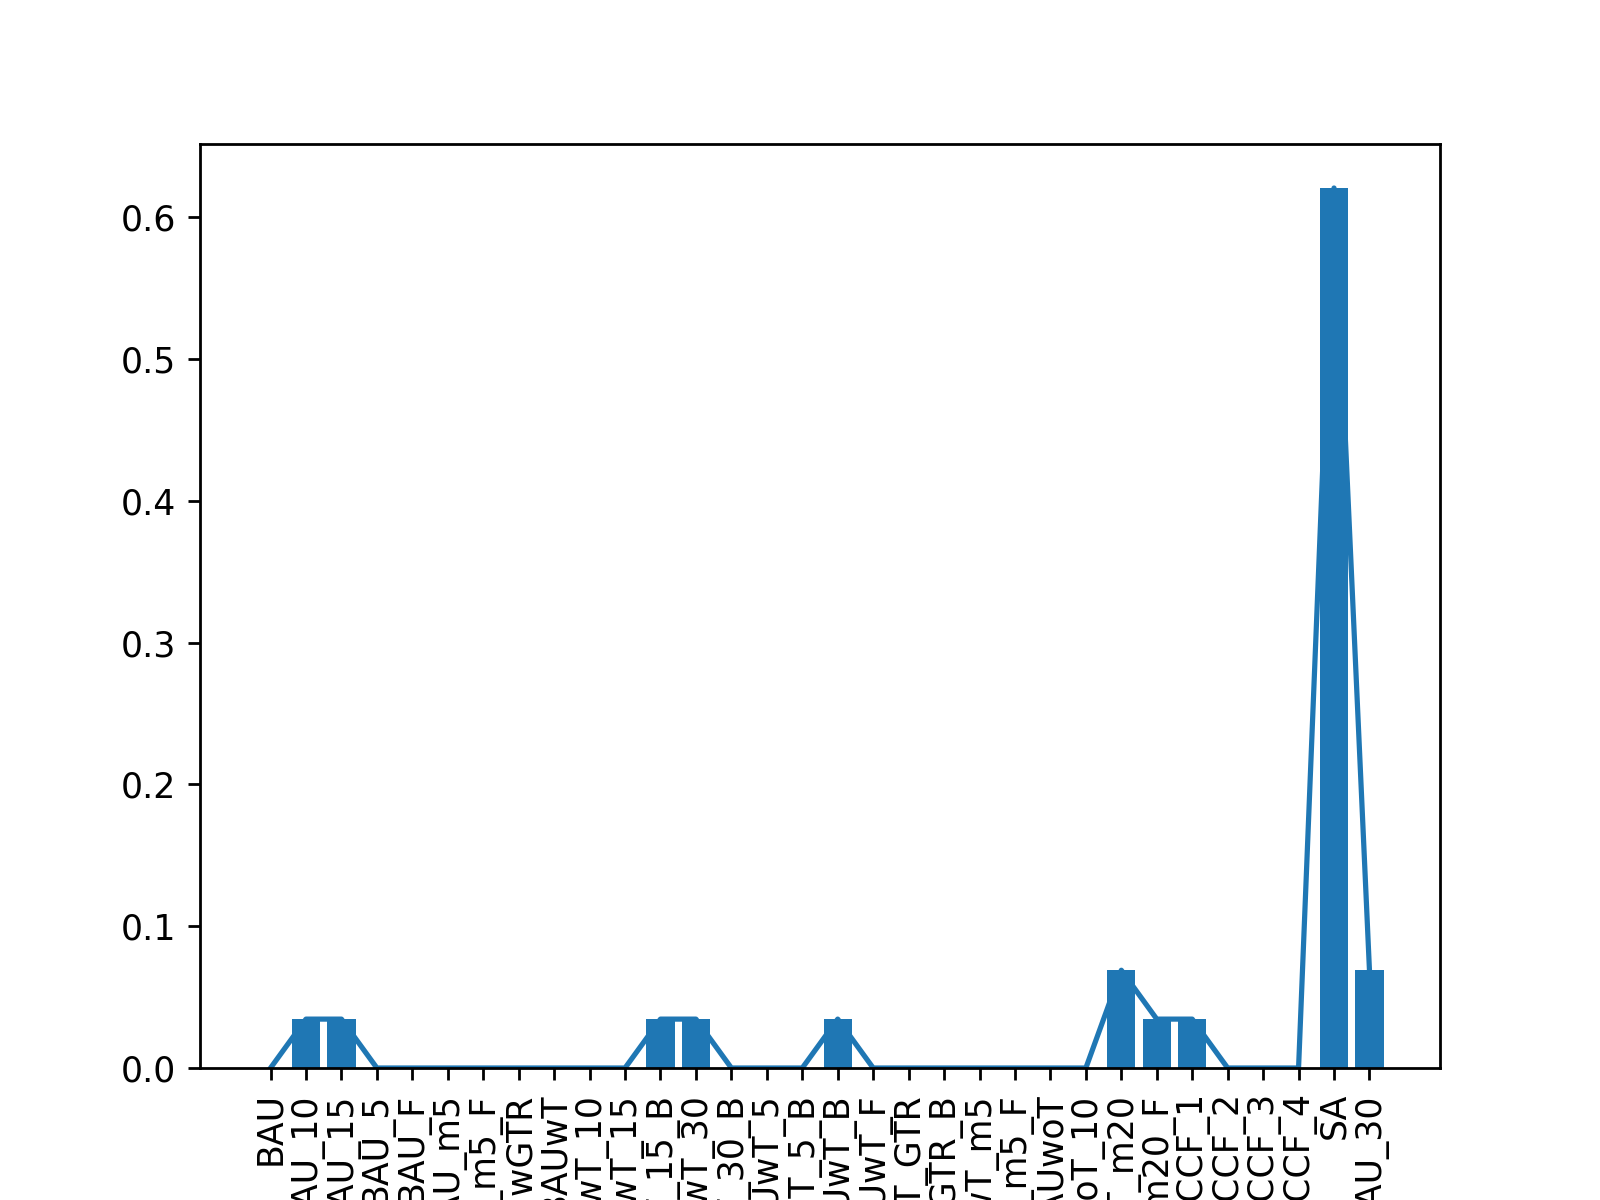

In [39]:
plt.plot([key for key in regimeAmounts.keys()],[val for val in regimeAmounts.values()])

In [40]:
plt.bar(range(len(regimeAmounts)), list(regimeAmounts.values()), align='center')
plt.xticks(range(len(regimeAmounts)), list(regimeAmounts.keys()),rotation="vertical")

([<matplotlib.axis.XTick at 0x7fa548dda8b0>,
 [Text(0, 0, 'BAU'),
  Text(1, 0, 'BAU_10'),
  Text(2, 0, 'BAU_15'),
  Text(3, 0, 'BAU_5'),
  Text(4, 0, 'BAU_F'),
  Text(5, 0, 'BAU_m5'),
  Text(6, 0, 'BAU_m5_F'),
  Text(7, 0, 'BAUwGTR'),
  Text(8, 0, 'BAUwT'),
  Text(9, 0, 'BAUwT_10'),
  Text(10, 0, 'BAUwT_15'),
  Text(11, 0, 'BAUwT_15_B'),
  Text(12, 0, 'BAUwT_30'),
  Text(13, 0, 'BAUwT_30_B'),
  Text(14, 0, 'BAUwT_5'),
  Text(15, 0, 'BAUwT_5_B'),
  Text(16, 0, 'BAUwT_B'),
  Text(17, 0, 'BAUwT_F'),
  Text(18, 0, 'BAUwT_GTR'),
  Text(19, 0, 'BAUwT_GTR_B'),
  Text(20, 0, 'BAUwT_m5'),
  Text(21, 0, 'BAUwT_m5_F'),
  Text(22, 0, 'BAUwoT'),
  Text(23, 0, 'BAUwoT_10'),
  Text(24, 0, 'BAUwoT_m20'),
  Text(25, 0, 'BAUwoT_m20_F'),
  Text(26, 0, 'CCF_1'),
  Text(27, 0, 'CCF_2'),
  Text(28, 0, 'CCF_3'),
  Text(29, 0, 'CCF_4'),
  Text(30, 0, 'SA'),
  Text(31, 0, 'BAU_30')])

## Export data as csv

- <b>Solution_alldata</b> contains the optimal regime per stand AND the timely development of indicator values plus all other input columns (represented_are_by_NFIplot, region, NUTS2)
- <b>Solution</b> contains only the selected optimal regime and its share (if multiple regimes per stand are selected)


In [41]:
try:
    os.mkdir("results")
except FileExistsError:
    pass
b = []
c = []
for key in mfo.regimesDecision.keys():
    if mfo.regimesDecision[key].solution_value() > 0:
        b = b+ [(key[0],x*5+2016, key[1]) for x in range(0,21)]
        c = c+ [(key[0],key[1],mfo.regimesDecision[key].solution_value())]
data2b = mfo.data.iloc[mfo.data.index.isin(b)]
data2b.to_csv("./results/solution_alldata_"+scenario+"_"+RCP+"_"+extension+".csv")
c1 = pd.DataFrame(c)
c1.to_csv("./results/solution_"+scenario+"_"+RCP+"_"+extension+".csv")

## Export objective ranges 

Save as json file

In [42]:
import json
mfo.objectiveRanges

with open('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json', 'w') as json_file:
  json.dump(mfo.objectiveRanges, json_file)

Save as CSV.

In [43]:
df = pd.read_json('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.json')

df.to_csv('./results/objectiveRanges_'+scenario+'_'+RCP+'_'+extension+'.csv')

## Export objective values
The optimal solution for each objective.

In [44]:
with open("./results/objectiveValues_"+scenario+'_'+RCP+'_'+extension+".csv","w") as file: 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+objName) 
        delim = "," 
    file.write("\n") 
    delim = "" 
    for objName in mfo.objectiveTypes.keys(): 
        file.write(delim+str(mfo.objective[objName].solution_value())) 
        delim = "," 
    file.write("\n")